<h3>Import Libraries</h3>

In [228]:
import math

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


<h3>Helper Functions</h3>

In [3]:
def f_indicator(boolean):
    return 1 if boolean else 0

In [4]:
def geometric_brownian_motion(z, t, s_0, mu, sigma):
    '''
    Simulate geometric brownian motion according to a given random normal distribution and time stamps
    ---------------------------
    Parameters
    z: array of standard normal distribution with size n
    t: list of time stamps with size n+1
    
    Return
    s: array of geometric brownian motion with size n+1 
    '''
    s = np.repeat(s_0, len(z)+1)
    for i in range(1, len(z)+1):
        s[i] = s[i-1]*math.exp((mu-0.5*sigma**2)*(t[i]-t[i-1])+sigma*z[i-1]*(t[i]-t[i-1])**0.5)
    return s

In [5]:
def real_stock_price_movement(s, t, r, dividends, t_dividends):
    '''
    Map geometric brownian motion simulation result to real stock price by adjusting with respect to 
    the dividend pay
    -----------------------------
    Parameters
    s: array of geometric brownian motion sample with size n+1
    t: array of time stamp corresponding to each sample with size n+1
    r: interest rate
    dividends: list of possible dividend
    t_dividends: list of time of dividend pay
    
    Return
    s_real: array of stock price movement with dividend correction
    '''
    s += get_dividend_adjustment(t, dividends, t_dividends, r)
    return s

In [6]:
def get_dividend_adjustment(t, dividends, t_dividends, r):
    '''
    Get the present value of dividend at time t with a certain dividend scheme specified
    -----------------------------
    Parameters
    t: list of time stamps
    dividends: list of possible dividend
    t_dividends: list of time of dividend pay
    r: interest rate
    
    Return
    d_t: dividend adjustment at time t (inclusive for dividend at time t)
    '''
    d_t = np.zeros(len(t), dtype=np.float32)
    for idx, time_stamp in enumerate(t):
        for t_dividend, dividend in zip(t_dividends, dividends):
            d_t[idx] += f_indicator(time_stamp<=t_dividend)*dividend*math.exp(-r*(t_dividend-time_stamp))
    return d_t

In [335]:
def american_option_payoff(s_real, K, r, t, t_dividends, thresholds):
    '''
    Calculate the payoff of an american option given a strategy defined by thresholds
    ----------------------------
    Parameters
    s_real: array of stock price movement with dividend correction
    K: exercise price
    r: interest rate
    t: list of time stamps in ascending order
    t_dividends: list of time of dividend pay in ascending order
    thresholds: list of threshold for determining execution of option
    
    Return:
    payoff: payoff from holding the option with a simulated stock price
    '''
    for threshold, t_dividend in zip(thresholds, t_dividends):
        if t_dividend not in t:
            raise ValueError("Some elements of t_dividends are not included in t.")
        idx = t.index(t_dividend)
        if s_real[idx] >= threshold:
            return (s_real[idx] - K) * math.exp(r*(-t_dividend))
    return max(0, s_real[-1]-K)*math.exp(-r*t[-1])

In [336]:
def simulate_american_option_payoff(z, t, s_0, mu, sigma, r, K, dividends, t_dividends,thresholds):
    '''
    Simulate american option payoff from an instance of a standard normal vector
    -------------------------------
    Parameters
    z: array of standard normal distribution with size n
    t: list of time stamps with size n+1
    s_0: initial stock price
    r: interest rate
    K: exercise price
    dividends: list of possible dividend
    t_dividends: list of time of dividend pay
    thresholds: list of threshold for determining execution of option

    Return:
    payoff: payoff from holding the option with a simulated stock price
    '''
    s = geometric_brownian_motion(z, t, s_0, mu, sigma)
    s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
    return american_option_payoff(s_real, K, r, t, t_dividends, thresholds)

<h3>Payoff Simulation</h3>

<h4>Simulate an instance of the real stock price movement for inspection</h4>

In [375]:
#Problem Parameters
t_dividends = [0.3, 0.6]
t_expiration = 0.9
dividends = [2,2]
thresholds = [60, 60]
s_0 = 50. #starting price
K = 50 #exercise price
mu = 0.1
sigma = 0.15
r = 0.1 #interest rate
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]

In [376]:
end_time = 0.9
step_size = 0.005
number_of_step = int(end_time/step_size)
t = [step_size*i for i in range(number_of_step+1)]

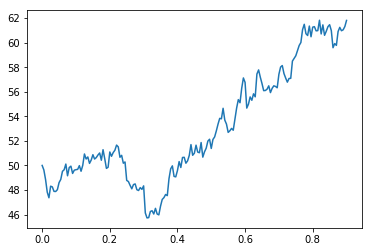

In [377]:
z = np.random.normal(size=len(t)-1)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.plot(t, s_real)

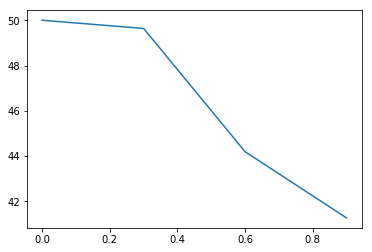

In [378]:
t = [0,0.3,0.6,0.9]
z = np.random.normal(size=len(t)-1)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.plot(t, s_real)

<p>Calcuate option payoff</p>

In [398]:
#Problem Parameters
t = [0,0.3,0.6,0.9]
t_dividends = [0.3, 0.6]
t_expiration = 0.9
dividends = [2,2]
thresholds = [60, 60]
s_0 = 50. #starting price
K = 50 #exercise price
mu = 0.1
r = 0.1 #interest rate
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]
option_price = 4.85

In [401]:
#Simulation Parameters
sigma = 2
n = 100000
delta = 1e-5

In [399]:
result = np.zeros(n)
for i in range(n):
    z = np.random.normal(size=len(t)-1)
    result[i] = simulate_american_option_payoff(z, t, s_0, mu, sigma, r, K, dividends, t_dividends,thresholds)
    update_direction = np.sign(simulate_american_option_payoff(z, t, s_0, mu, sigma+delta, r, K, dividends, t_dividends,thresholds)-
                               simulate_american_option_payoff(z, t, s_0, mu, sigma-delta, r, K, dividends, t_dividends,thresholds))
    update_magnitude = (result[i] - option_price)
    

In [400]:
result.mean()

28.636241724067101

In [397]:
result.std()

5.2935370041004397

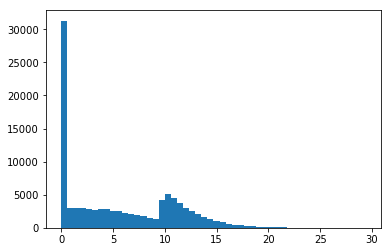

In [389]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(result, 50)
plt.show()

<h3>Real stock price simulation example</h3>

In [332]:
end_time = 10
step_size = 0.05
number_of_step = int(end_time/step_size)

In [333]:
s_0 = 50.
t = [step_size*i for i in range(number_of_step+1)]
t_dividends = [0.3,0.6]
dividends = [2, 2]
mu = 0.1
sigma = 0.2
r = 0.4
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]

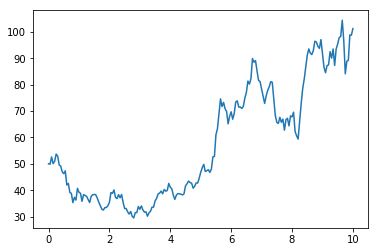

In [334]:
z = np.random.normal(size=number_of_step)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.plot(t, s_real)